# Base Model - LSTM

### Imports

In [1]:
from fredapi import Fred
import pandas as pd
import numpy as np
import pandas_ta as ta
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import load_model

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",100)

2024-12-12 16:57:03.827520: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 16:57:03.827544: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 16:57:03.827550: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 16:57:03.831840: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Economic Data 

In [2]:

# Initialize Fred with your API key
fred = Fred(api_key='db61e0d65c4d2a1053221aec21822d4e')  # Replace with your actual API key securely

# Define date range
start_date = '2002-01-01'
end_date = '2024-12-12'

# Define the indicators and their series IDs
indicators = {
    'Effective Federal Funds Rate': 'FEDFUNDS',
    '10-Year Treasury Rate': 'DGS10',
    'Consumer Price Index': 'CPIAUCSL',
    'Producer Price Index': 'PPIACO',
    'Unemployment Rate': 'UNRATE',
    'Nonfarm Payroll Employment': 'PAYEMS',
    'Real GDP': 'GDPC1',
    'Housing Starts': 'HOUST',
    'Industrial Production Index': 'INDPRO',
    'M2 Money Stock': 'M2SL',
    'Crude Oil Prices': 'DCOILWTICO',
    'Retail Sales': 'RSXFS',  # Corrected series ID for Retail Sales
    'Total Business Inventories': 'BUSINV'
}

# Fetch the data with date range
economic_data = pd.DataFrame()

for name, series_id in indicators.items():
    try:
        data = fred.get_series(
            series_id,
            observation_start=start_date,
            observation_end=end_date
        )
        if data is not None and not data.empty:
            economic_data[name] = data
            print(f"Successfully fetched data for {name}")
    except Exception as e:
        print(f"Error fetching {name}: {e}")

# Convert index to datetime if not already
economic_data.index = pd.to_datetime(economic_data.index)

Successfully fetched data for Effective Federal Funds Rate
Successfully fetched data for 10-Year Treasury Rate
Successfully fetched data for Consumer Price Index
Successfully fetched data for Producer Price Index
Successfully fetched data for Unemployment Rate
Successfully fetched data for Nonfarm Payroll Employment
Successfully fetched data for Real GDP
Successfully fetched data for Housing Starts
Successfully fetched data for Industrial Production Index
Successfully fetched data for M2 Money Stock
Successfully fetched data for Crude Oil Prices
Successfully fetched data for Retail Sales
Successfully fetched data for Total Business Inventories


In [4]:
economic_data.tail()

,Effective Federal Funds Rate,10-Year Treasury Rate,Consumer Price Index,Producer Price Index,Unemployment Rate,Nonfarm Payroll Employment,Real GDP,Housing Starts,Industrial Production Index,M2 Money Stock,Crude Oil Prices,Retail Sales,Total Business Inventories
2024-07-01,5.33,4.48,313.534,257.321,4.3,158692.0,23386.733,1262.0,102.5381,21039.4,84.70,615960.0,2574892.0
2024-08-01,5.33,3.99,314.121,255.430,4.2,158770.0,NaN,1379.0,103.0449,21141.3,77.74,614535.0,2583708.0
2024-09-01,5.13,NaN,314.686,252.690,4.1,159025.0,NaN,1353.0,102.5497,21222.7,NaN,619411.0,2587145.0
2024-10-01,4.83,3.74,315.454,253.162,4.1,159061.0,NaN,1311.0,102.2805,21311.2,70.41,621590.0,NaN
2024-11-01,4.64,4.37,316.441,253.406,4.2,159288.0,NaN,NaN,NaN,NaN,69.81,NaN,NaN


In [5]:
economic_data.shape

(275, 13)

In [6]:
economic_data.to_csv('economic_data_new.csv')

In [7]:
economic_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 275 entries, 2002-01-01 to 2024-11-01
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Effective Federal Funds Rate  275 non-null    float64
 1   10-Year Treasury Rate         179 non-null    float64
 2   Consumer Price Index          275 non-null    float64
 3   Producer Price Index          275 non-null    float64
 4   Unemployment Rate             275 non-null    float64
 5   Nonfarm Payroll Employment    275 non-null    float64
 6   Real GDP                      91 non-null     float64
 7   Housing Starts                274 non-null    float64
 8   Industrial Production Index   274 non-null    float64
 9   M2 Money Stock                274 non-null    float64
 10  Crude Oil Prices              179 non-null    float64
 11  Retail Sales                  274 non-null    float64
 12  Total Business Inventories    273 non-null   

In [8]:

# Ensure the DataFrame is sorted by date
economic_data.sort_index(inplace=True)

# Fill missing values
def fill_missing_values(df):
    df_filled = df.copy()

    # Ensure index is DatetimeIndex
    if not isinstance(df_filled.index, pd.DatetimeIndex):
        df_filled.index = pd.to_datetime(df_filled.index)
    df_filled.sort_index(inplace=True)

    # Create Month and Year columns once
    df_filled['Month'] = df_filled.index.month
    df_filled['Year'] = df_filled.index.year

    # Process each column individually
    for column in df.columns:
        col_data = df_filled[['Year', 'Month', column]].copy()

        # Calculate monthly means
        monthly_means = col_data.groupby(['Year', 'Month'])[column].mean().rename('Monthly_Mean').reset_index()

        # Merge monthly means back into col_data
        col_data = col_data.merge(monthly_means, on=['Year', 'Month'], how='left')

        # Fill missing values with Monthly Mean
        null_mask = col_data[column].isnull()
        col_data.loc[null_mask, column] = col_data.loc[null_mask, 'Monthly_Mean']

        # Calculate yearly means
        yearly_means = col_data.groupby('Year')[column].mean().rename('Yearly_Mean').reset_index()

        # Merge yearly means into col_data
        col_data = col_data.merge(yearly_means, on='Year', how='left')

        # Fill remaining missing values with Yearly Mean
        still_null_mask = col_data[column].isnull()
        col_data.loc[still_null_mask, column] = col_data.loc[still_null_mask, 'Yearly_Mean']

        # Update the filled values back into df_filled
        df_filled.loc[:, column] = col_data[column].values

    # Drop the auxiliary columns
    df_filled.drop(['Month', 'Year'], axis=1, inplace=True)

    return df_filled


# Apply the function to fill missing values
economic_data_filled = fill_missing_values(economic_data)
if not isinstance(economic_data_filled.index, pd.DatetimeIndex):
    economic_data_filled.index = pd.to_datetime(economic_data_filled.index)
# Ensure the DataFrame is sorted by date
economic_data_filled.sort_index(inplace=True)
print(economic_data_filled.index)
# Preview the filled data
print(economic_data_filled.head())

DatetimeIndex(['2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01',
               '2002-05-01', '2002-06-01', '2002-07-01', '2002-08-01',
               '2002-09-01', '2002-10-01',
               ...
               '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01',
               '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01',
               '2024-10-01', '2024-11-01'],
              dtype='datetime64[ns]', length=275, freq=None)
            Effective Federal Funds Rate  10-Year Treasury Rate  \
2002-01-01                          1.73                4.69625   
2002-02-01                          1.74                5.02000   
2002-03-01                          1.73                4.98000   
2002-04-01                          1.75                5.44000   
2002-05-01                          1.75                5.08000   

            Consumer Price Index  Producer Price Index  Unemployment Rate  \
2002-01-01                 177.7                 128.5               

In [9]:
print(economic_data_filled.isna().sum())

Effective Federal Funds Rate    0
10-Year Treasury Rate           0
Consumer Price Index            0
Producer Price Index            0
Unemployment Rate               0
Nonfarm Payroll Employment      0
Real GDP                        0
Housing Starts                  0
Industrial Production Index     0
M2 Money Stock                  0
Crude Oil Prices                0
Retail Sales                    0
Total Business Inventories      0
dtype: int64


In [10]:
economic_data_filled.tail(5)

,Effective Federal Funds Rate,10-Year Treasury Rate,Consumer Price Index,Producer Price Index,Unemployment Rate,Nonfarm Payroll Employment,Real GDP,Housing Starts,Industrial Production Index,M2 Money Stock,Crude Oil Prices,Retail Sales,Total Business Inventories
2024-07-01,5.33,4.48,313.534,257.321,4.3,158692.0,23386.733000,1262.0,102.53810,21039.40,84.700,615960.0,2.574892e+06
2024-08-01,5.33,3.99,314.121,255.430,4.2,158770.0,23221.394667,1379.0,103.04490,21141.30,77.740,614535.0,2.583708e+06
2024-09-01,5.13,4.20,314.686,252.690,4.1,159025.0,23221.394667,1353.0,102.54970,21222.70,77.895,619411.0,2.587145e+06
2024-10-01,4.83,3.74,315.454,253.162,4.1,159061.0,23221.394667,1311.0,102.28050,21311.20,70.410,621590.0,2.558768e+06
2024-11-01,4.64,4.37,316.441,253.406,4.2,159288.0,23221.394667,1354.7,102.57548,20992.64,69.810,611665.1,2.558768e+06


In [11]:
economic_data_filled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 275 entries, 2002-01-01 to 2024-11-01
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Effective Federal Funds Rate  275 non-null    float64
 1   10-Year Treasury Rate         275 non-null    float64
 2   Consumer Price Index          275 non-null    float64
 3   Producer Price Index          275 non-null    float64
 4   Unemployment Rate             275 non-null    float64
 5   Nonfarm Payroll Employment    275 non-null    float64
 6   Real GDP                      275 non-null    float64
 7   Housing Starts                275 non-null    float64
 8   Industrial Production Index   275 non-null    float64
 9   M2 Money Stock                275 non-null    float64
 10  Crude Oil Prices              275 non-null    float64
 11  Retail Sales                  275 non-null    float64
 12  Total Business Inventories    275 non-null   

### Stock Data

In [12]:
stock_data = pd.read_parquet('sp50_data_new.parquet')
# Convert index to DatetimeIndex if not already
if not isinstance(stock_data.index, pd.DatetimeIndex):
    stock_data.index = pd.to_datetime(stock_data.index)

# Sort by date
stock_data.sort_index(inplace=True)
stock_data.tail(5)

Ticker           GOOGL                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2024-12-05  175.360001  176.059998  172.330002  172.639999  172.442368   
2024-12-06  172.029999  175.080002  171.860001  174.710007  174.510010   
2024-12-09  173.960007  176.259995  173.649994  175.369995  175.369995   
2024-12-10  182.850006  186.360001  181.050003  185.169998  185.169998   
2024-12-11  185.309998  195.610001  184.850006  195.399994  195.399994   

Ticker                        ISRG                                      \
Price           Volume        Open        High         Low       Close   
Date                                                                     
2024-12-05  21356200.0  548.000000  551.809998  544.429993  547.650024   
2024-12-06  21462400.0  548.210022  556.229980  548.210022  550.409973   
2024-12-09  25389600.0  552.309998  553.559998  532.140015  538.859985   
2024-12-10  54813000.0  540.159973  543.330017  536.679993  538.090027   
2024-12-11  67656700.0  538.219971  548.530029  538.219971  543.599976   

Ticker                                 MSFT                          \
Price        Adj Close   Volume        Open        High         Low   
Date                                                                  
2024-12-05  547.650024   945200  437.920013  444.660004  436.170013   
2024-12-06  550.409973  1026200  442.299988  446.100006  441.769989   
2024-12-09  538.859985  1429200  442.600006  448.329987  440.500000   
2024-12-10  538.090027  1048000  444.390015  449.619995  441.600006   
2024-12-11  543.599976   999400  444.049988  450.350006  444.049988   

Ticker                                              NFLX              \
Price            Close   Adj Close    Volume        Open        High   
Date                                                                   
2024-12-05  442.619995  442.619995  21697800  917.849976  927.000000   
2024-12-06  443.570007  443.570007  18821000  915.229980  935.270020   
2024-12-09  446.019989  446.019989  19144400  928.000000  930.299988   
2024-12-10  443.329987  443.329987  18469500  913.760010  922.880005   
2024-12-11  448.989990  448.989990  19110100  924.710022  941.750000   

Ticker                                                           NOW  \
Price              Low       Close   Adj Close   Volume         Open   
Date                                                                   
2024-12-05  911.109985  917.869995  917.869995  2835300  1115.099976   
2024-12-06  912.710022  934.739990  934.739990  2955400  1135.619995   
2024-12-09  902.590027  913.690002  913.690002  3350100  1124.199951   
2024-12-10  909.580017  913.349976  913.349976  2388600  1114.020020   
2024-12-11  923.080017  936.559998  936.559998  3493500  1136.040039   

Ticker                                                                     \
Price              High          Low        Close    Adj Close     Volume   
Date                                                                        
2024-12-05  1130.599976  1113.109985  1123.719971  1123.719971  1075500.0   
2024-12-06  1137.000000  1120.000000  1124.339966  1124.339966   904400.0   
2024-12-09  1134.020020  1105.709961  1120.479980  1120.479980  1223400.0   
2024-12-10  1147.369995  1114.020020  1127.839966  1127.839966  1599200.0   
2024-12-11  1157.900024  1136.040039  1147.180054  1147.180054  1244800.0   

Ticker            AAPL                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2024-12-05  243.990005  244.539993  242.130005  243.039993  243.039993   
2024-12-06  242.910004  244.630005  242.080002  242.839996  242.839996   
2024-12-09  241.830002  247.240005  241.750000  246.750000  246.750000   
2024-12-10  246.889999  248.21

In [13]:
print(f"Economic data date range: {economic_data_filled.index.min()} to {economic_data_filled.index.max()}")
print(f"Stock data date range: {stock_data.index.min()} to {stock_data.index.max()}")

Economic data date range: 2002-01-01 00:00:00 to 2024-11-01 00:00:00
Stock data date range: 2003-01-02 00:00:00 to 2024-12-11 00:00:00


In [14]:
stock_data.columns

MultiIndex([('GOOGL',      'Open'),
            ('GOOGL',      'High'),
            ('GOOGL',       'Low'),
            ('GOOGL',     'Close'),
            ('GOOGL', 'Adj Close'),
            ('GOOGL',    'Volume'),
            ( 'ISRG',      'Open'),
            ( 'ISRG',      'High'),
            ( 'ISRG',       'Low'),
            ( 'ISRG',     'Close'),
            ...
            (  'DHR',       'Low'),
            (  'DHR',     'Close'),
            (  'DHR', 'Adj Close'),
            (  'DHR',    'Volume'),
            (  'IBM',      'Open'),
            (  'IBM',      'High'),
            (  'IBM',       'Low'),
            (  'IBM',     'Close'),
            (  'IBM', 'Adj Close'),
            (  'IBM',    'Volume')],
           names=['Ticker', 'Price'], length=300)

In [15]:
stock_data.index

DatetimeIndex(['2003-01-02', '2003-01-03', '2003-01-06', '2003-01-07',
               '2003-01-08', '2003-01-09', '2003-01-10', '2003-01-13',
               '2003-01-14', '2003-01-15',
               ...
               '2024-11-27', '2024-11-29', '2024-12-02', '2024-12-03',
               '2024-12-04', '2024-12-05', '2024-12-06', '2024-12-09',
               '2024-12-10', '2024-12-11'],
              dtype='datetime64[ns]', name='Date', length=5524, freq=None)

In [16]:
economic_data_filled.index

DatetimeIndex(['2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01',
               '2002-05-01', '2002-06-01', '2002-07-01', '2002-08-01',
               '2002-09-01', '2002-10-01',
               ...
               '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01',
               '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01',
               '2024-10-01', '2024-11-01'],
              dtype='datetime64[ns]', length=275, freq=None)

In [17]:
# Flatten MultiIndex columns in stock_data
stock_data.columns = ['_'.join(col).strip() for col in stock_data.columns.values]

In [18]:
economic_data_filled.index.name = 'Date'
stock_data.index.name = 'Date'

# Create a daily date range based on stock data index
daily_date_range = pd.date_range(
    start=stock_data.index.min(),
    end=stock_data.index.max(),
    freq='D'  # Daily frequency
)

# Reindex economic data to daily frequency using forward fill
economic_data_daily = economic_data_filled.reindex(daily_date_range, method='ffill')

# Ensure the index name is consistent
economic_data_daily.index.name = 'Date'

# Merge the DataFrames using the date index
combined_data = stock_data.join(economic_data_daily, how='left')

# Check for missing values after merging
missing_values = combined_data.isna().sum()
print("Missing values after merging:")
print(missing_values)

Missing values after merging:
GOOGL_Open                     410
GOOGL_High                     410
GOOGL_Low                      410
GOOGL_Close                    410
GOOGL_Adj Close                410
                              ... 
Industrial Production Index      0
M2 Money Stock                   0
Crude Oil Prices                 0
Retail Sales                     0
Total Business Inventories       0
Length: 313, dtype: int64


In [19]:
# Optionally, forward fill remaining missing values
combined_data.ffill(inplace=True)

###  Additional Feature Engineering


In [20]:
tickers = ["AAPL", "NVDA", "MSFT", "GOOG", "GOOGL", "AMZN", "META", "AVGO", "LLY", "TSLA",
                 "WMT", "JPM", "V", "XOM", "UNH", "ORCL", "MA", "HD", "PG", "COST", "JNJ",
                 "NFLX", "ABBV", "BAC", "KO", "CRM", "CVX", "MRK", "TMUS", "AMD", "PEP",
                 "ACN", "LIN", "TMO", "MCD", "CSCO", "ADBE", "WFC", "IBM", "GE", "ABT",
                 "DHR", "AXP", "MS", "CAT", "NOW", "QCOM", "PM", "ISRG", "VZ"]

print(len(combined_data.columns))

for ticker in tickers:
    close_col = f'{ticker}_Close'

    if close_col in combined_data.columns:
        # Calculate SMA (Simple Moving Average)
        combined_data[f'{ticker}_SMA_20'] = ta.sma(combined_data[close_col], length=20)

        # Calculate RSI (Relative Strength Index)
        combined_data[f'{ticker}_RSI_14'] = ta.rsi(combined_data[close_col], length=14)

        # Calculate MACD (Moving Average Convergence Divergence)
        macd = ta.macd(combined_data[close_col], fast=12, slow=26)
        macd_columns = [f'{ticker}_MACD', f'{ticker}_MACD_Hist', f'{ticker}_MACD_Signal']
        macd.columns = macd_columns
        combined_data = pd.concat([combined_data, macd], axis=1)

        # Calculate Bollinger Bands
        bbands = ta.bbands(combined_data[close_col], length=20)
        bbands_columns = [f'{ticker}_BB_Lower', f'{ticker}_BB_Middle', f'{ticker}_BB_Upper', f'{ticker}_BB_Bandwidth', f'{ticker}_BB_Percentage']
        bbands.columns = bbands_columns
        combined_data = pd.concat([combined_data, bbands], axis=1)

        # Calculate Momentum
        combined_data[f'{ticker}_MOM_10'] = ta.mom(combined_data[close_col], length=10)
    else:
        print(f'Column {close_col} not found in combined_data.')

print(len(combined_data.columns))
combined_data.head(1)

313
863


,GOOGL_Open,GOOGL_High,GOOGL_Low,GOOGL_Close,GOOGL_Adj Close,GOOGL_Volume,ISRG_Open,ISRG_High,ISRG_Low,ISRG_Close,ISRG_Adj Close,ISRG_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Adj Close,MSFT_Volume,NFLX_Open,NFLX_High,NFLX_Low,NFLX_Close,NFLX_Adj Close,NFLX_Volume,NOW_Open,NOW_High,NOW_Low,NOW_Close,NOW_Adj Close,NOW_Volume,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,META_Open,META_High,META_Low,META_Close,META_Adj Close,META_Volume,AVGO_Open,AVGO_High,AVGO_Low,AVGO_Close,AVGO_Adj Close,AVGO_Volume,ACN_Open,ACN_High,ACN_Low,ACN_Close,ACN_Adj Close,ACN_Volume,TSLA_Open,TSLA_High,TSLA_Low,TSLA_Close,TSLA_Adj Close,TSLA_Volume,ABBV_Open,ABBV_High,ABBV_Low,ABBV_Close,ABBV_Adj Close,ABBV_Volume,PM_Open,PM_High,PM_Low,PM_Close,PM_Adj Close,PM_Volume,MCD_Open,MCD_High,MCD_Low,MCD_Close,MCD_Adj Close,MCD_Volume,CAT_Open,CAT_High,CAT_Low,CAT_Close,CAT_Adj Close,CAT_Volume,XOM_Open,XOM_High,XOM_Low,XOM_Close,XOM_Adj Close,XOM_Volume,NVDA_Open,NVDA_High,NVDA_Low,NVDA_Close,NVDA_Adj Close,NVDA_Volume,BAC_Open,BAC_High,BAC_Low,BAC_Close,BAC_Adj Close,BAC_Volume,CRM_Open,CRM_High,CRM_Low,CRM_Close,CRM_Adj Close,CRM_Volume,PEP_Open,PEP_High,PEP_Low,PEP_Close,PEP_Adj Close,PEP_Volume,VZ_Open,VZ_High,VZ_Low,VZ_Close,VZ_Adj Close,VZ_Volume,JNJ_Open,JNJ_High,JNJ_Low,JNJ_Close,JNJ_Adj Close,JNJ_Volume,CVX_Open,CVX_High,CVX_Low,CVX_Close,CVX_Adj Close,CVX_Volume,V_Open,V_High,V_Low,V_Close,V_Adj Close,V_Volume,KO_Open,KO_High,KO_Low,KO_Close,KO_Adj Close,KO_Volume,CSCO_Open,CSCO_High,CSCO_Low,CSCO_Close,CSCO_Adj Close,CSCO_Volume,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Adj Close,AMD_Volume,HD_Open,HD_High,HD_Low,HD_Close,HD_Adj Close,HD_Volume,MA_Open,MA_High,MA_Low,MA_Close,MA_Adj Close,MA_Volume,ORCL_Open,ORCL_High,ORCL_Low,ORCL_Close,ORCL_Adj Close,ORCL_Volume,MS_Open,MS_High,MS_Low,MS_Close,MS_Adj Close,MS_Volume,TMUS_Open,TMUS_High,TMUS_Low,TMUS_Close,TMUS_Adj Close,TMUS_Volume,LLY_Open,LLY_High,LLY_Low,LLY_Close,LLY_Adj Close,LLY_Volume,COST_Open,COST_High,COST_Low,COST_Close,COST_Adj Close,COST_Volume,ABT_Open,ABT_High,ABT_Low,ABT_Close,ABT_Adj Close,ABT_Volume,QCOM_Open,QCOM_High,QCOM_Low,QCOM_Close,QCOM_Adj Close,QCOM_Volume,GOOG_Open,GOOG_High,GOOG_Low,GOOG_Close,GOOG_Adj Close,GOOG_Volume,GE_Open,GE_High,GE_Low,GE_Close,GE_Adj Close,GE_Volume,WMT_Open,WMT_High,WMT_Low,WMT_Close,WMT_Adj Close,WMT_Volume,UNH_Open,UNH_High,UNH_Low,UNH_Close,UNH_Adj Close,UNH_Volume,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Adj Close,AMZN_Volume,AXP_Open,AXP_High,AXP_Low,AXP_Close,AXP_Adj Close,AXP_Volume,TMO_Open,TMO_High,TMO_Low,TMO_Close,TMO_Adj Close,TMO_Volume,JPM_Open,JPM_High,JPM_Low,JPM_Close,JPM_Adj Close,JPM_Volume,ADBE_Open,ADBE_High,ADBE_Low,ADBE_Close,ADBE_Adj Close,ADBE_Volume,MRK_Open,MRK_High,MRK_Low,MRK_Close,MRK_Adj Close,MRK_Volume,LIN_Open,LIN_High,LIN_Low,LIN_Close,LIN_Adj Close,LIN_Volume,PG_Open,PG_High,PG_Low,PG_Close,PG_Adj Close,PG_Volume,WFC_Open,WFC_High,WFC_Low,WFC_Close,WFC_Adj Close,WFC_Volume,DHR_Open,DHR_High,DHR_Low,DHR_Close,DHR_Adj Close,DHR_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Adj Close,IBM_Volume,Effective Federal Funds Rate,10-Year Treasury Rate,Consumer Price Index,Producer Price Index,Unemployment Rate,Nonfarm Payroll Employment,Real GDP,Housing Starts,Industrial Production Index,M2 Money Stock,Crude Oil Prices,Retail Sales,Total Business Inventories,AAPL_SMA_20,AAPL_RSI_14,AAPL_MACD,AAPL_MACD_Hist,AAPL_MACD_Signal,AAPL_BB_Lower,AAPL_BB_Middle,AAPL_BB_Upper,AAPL_BB_Bandwidth,AAPL_BB_Percentage,AAPL_MOM_10,NVDA_SMA_20,NVDA_RSI_14,NVDA_MACD,NVDA_MACD_Hist,NVDA_MACD_Signal,NVDA_BB_Lower,NVDA_BB_Middle,NVDA_BB_Upper,NVDA_BB_Bandwidth,NVDA_BB_Percentage,NVDA_MOM_10,MSFT_SMA_20,MSFT_RSI_14,MSFT_MACD,MSFT_MACD_Hist,MSFT_MACD_Signal,MSFT_BB_Lower,MSFT_BB_Middle,MSFT_BB_Upper,MSFT_BB_Bandwidth,MSFT_BB_Percentage,MSFT_MOM_10,GOOG_SMA_20,GOOG_RSI_14,GOOG_MACD,GOOG_MACD_Hist,GOOG_MACD_Signal,GOOG_BB_Lower,GOOG_BB_Middle,GOOG_BB_Upper,GOOG_BB_Bandwidth,GOOG_BB_Percentage,GOOG_MOM_10,G

In [21]:
# Number of lags
n_lags = 5

# Initialize an empty dictionary to store lagged features
lagged_features = {}

# Create lag features for stock prices
for ticker in tickers:
    close_col = f'{ticker}_Close'

    if close_col in combined_data.columns:
        for lag in range(1, n_lags + 1):
            lag_col_name = f'{ticker}_Close_Lag_{lag}'
            lagged_features[lag_col_name] = combined_data[close_col].shift(lag)
    else:
        print(f'Column {close_col} not found in combined_data.')

# Create lag features for economic indicators
economic_indicators = economic_data_filled.columns.tolist()

for indicator in economic_indicators:
    if indicator in combined_data.columns:
        for lag in range(1, n_lags + 1):
            lag_col_name = f'{indicator}_Lag_{lag}'
            lagged_features[lag_col_name] = combined_data[indicator].shift(lag)
    else:
        print(f'Indicator {indicator} not found in combined_data.')

# Convert the lagged features dictionary to a DataFrame
lagged_features_df = pd.DataFrame(lagged_features, index=combined_data.index)

# Concatenate the lagged features DataFrame to the original DataFrame
combined_data = pd.concat([combined_data, lagged_features_df], axis=1)

# Optionally, defragment the DataFrame to improve performance
combined_data = combined_data.copy()

# Print the number of columns
print(f"Total number of columns: {len(combined_data.columns)}")

Total number of columns: 1178


In [24]:
# Extract Date-Based Features

import holidays

# Extract day of the week
combined_data['Day_of_Week'] = combined_data.index.dayofweek  # Monday=0, Sunday=6

# Extract month
combined_data['Month'] = combined_data.index.month

# Extract quarter
combined_data['Quarter'] = combined_data.index.quarter

# Identify US holidays
us_holidays = holidays.US()
combined_data['Is_Holiday'] = combined_data.index.isin(us_holidays).astype(int)

# Identify month start and end
combined_data['Is_Month_Start'] = combined_data.index.is_month_start.astype(int)
combined_data['Is_Month_End'] = combined_data.index.is_month_end.astype(int)
combined_data.head(1)

,GOOGL_Open,GOOGL_High,GOOGL_Low,GOOGL_Close,GOOGL_Adj Close,GOOGL_Volume,ISRG_Open,ISRG_High,ISRG_Low,ISRG_Close,ISRG_Adj Close,ISRG_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Adj Close,MSFT_Volume,NFLX_Open,NFLX_High,NFLX_Low,NFLX_Close,NFLX_Adj Close,NFLX_Volume,NOW_Open,NOW_High,NOW_Low,NOW_Close,NOW_Adj Close,NOW_Volume,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,META_Open,META_High,META_Low,META_Close,META_Adj Close,META_Volume,AVGO_Open,AVGO_High,AVGO_Low,AVGO_Close,AVGO_Adj Close,AVGO_Volume,ACN_Open,ACN_High,ACN_Low,ACN_Close,ACN_Adj Close,ACN_Volume,TSLA_Open,TSLA_High,TSLA_Low,TSLA_Close,TSLA_Adj Close,TSLA_Volume,ABBV_Open,ABBV_High,ABBV_Low,ABBV_Close,ABBV_Adj Close,ABBV_Volume,PM_Open,PM_High,PM_Low,PM_Close,PM_Adj Close,PM_Volume,MCD_Open,MCD_High,MCD_Low,MCD_Close,MCD_Adj Close,MCD_Volume,CAT_Open,CAT_High,CAT_Low,CAT_Close,CAT_Adj Close,CAT_Volume,XOM_Open,XOM_High,XOM_Low,XOM_Close,XOM_Adj Close,XOM_Volume,NVDA_Open,NVDA_High,NVDA_Low,NVDA_Close,NVDA_Adj Close,NVDA_Volume,BAC_Open,BAC_High,BAC_Low,BAC_Close,BAC_Adj Close,BAC_Volume,CRM_Open,CRM_High,CRM_Low,CRM_Close,CRM_Adj Close,CRM_Volume,PEP_Open,PEP_High,PEP_Low,PEP_Close,PEP_Adj Close,PEP_Volume,VZ_Open,VZ_High,VZ_Low,VZ_Close,VZ_Adj Close,VZ_Volume,JNJ_Open,JNJ_High,JNJ_Low,JNJ_Close,JNJ_Adj Close,JNJ_Volume,CVX_Open,CVX_High,CVX_Low,CVX_Close,CVX_Adj Close,CVX_Volume,V_Open,V_High,V_Low,V_Close,V_Adj Close,V_Volume,KO_Open,KO_High,KO_Low,KO_Close,KO_Adj Close,KO_Volume,CSCO_Open,CSCO_High,CSCO_Low,CSCO_Close,CSCO_Adj Close,CSCO_Volume,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Adj Close,AMD_Volume,HD_Open,HD_High,HD_Low,HD_Close,HD_Adj Close,HD_Volume,MA_Open,MA_High,MA_Low,MA_Close,MA_Adj Close,MA_Volume,ORCL_Open,ORCL_High,ORCL_Low,ORCL_Close,ORCL_Adj Close,ORCL_Volume,MS_Open,MS_High,MS_Low,MS_Close,MS_Adj Close,MS_Volume,TMUS_Open,TMUS_High,TMUS_Low,TMUS_Close,TMUS_Adj Close,TMUS_Volume,LLY_Open,LLY_High,LLY_Low,LLY_Close,LLY_Adj Close,LLY_Volume,COST_Open,COST_High,COST_Low,COST_Close,COST_Adj Close,COST_Volume,ABT_Open,ABT_High,ABT_Low,ABT_Close,ABT_Adj Close,ABT_Volume,QCOM_Open,QCOM_High,QCOM_Low,QCOM_Close,QCOM_Adj Close,QCOM_Volume,GOOG_Open,GOOG_High,GOOG_Low,GOOG_Close,GOOG_Adj Close,GOOG_Volume,GE_Open,GE_High,GE_Low,GE_Close,GE_Adj Close,GE_Volume,WMT_Open,WMT_High,WMT_Low,WMT_Close,WMT_Adj Close,WMT_Volume,UNH_Open,UNH_High,UNH_Low,UNH_Close,UNH_Adj Close,UNH_Volume,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Adj Close,AMZN_Volume,AXP_Open,AXP_High,AXP_Low,AXP_Close,AXP_Adj Close,AXP_Volume,TMO_Open,TMO_High,TMO_Low,TMO_Close,TMO_Adj Close,TMO_Volume,JPM_Open,JPM_High,JPM_Low,JPM_Close,JPM_Adj Close,JPM_Volume,ADBE_Open,ADBE_High,ADBE_Low,ADBE_Close,ADBE_Adj Close,ADBE_Volume,MRK_Open,MRK_High,MRK_Low,MRK_Close,MRK_Adj Close,MRK_Volume,LIN_Open,LIN_High,LIN_Low,LIN_Close,LIN_Adj Close,LIN_Volume,PG_Open,PG_High,PG_Low,PG_Close,PG_Adj Close,PG_Volume,WFC_Open,WFC_High,WFC_Low,WFC_Close,WFC_Adj Close,WFC_Volume,DHR_Open,DHR_High,DHR_Low,DHR_Close,DHR_Adj Close,DHR_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Adj Close,IBM_Volume,Effective Federal Funds Rate,10-Year Treasury Rate,Consumer Price Index,Producer Price Index,Unemployment Rate,Nonfarm Payroll Employment,Real GDP,Housing Starts,Industrial Production Index,M2 Money Stock,Crude Oil Prices,Retail Sales,Total Business Inventories,AAPL_SMA_20,AAPL_RSI_14,AAPL_MACD,AAPL_MACD_Hist,AAPL_MACD_Signal,AAPL_BB_Lower,AAPL_BB_Middle,AAPL_BB_Upper,AAPL_BB_Bandwidth,AAPL_BB_Percentage,AAPL_MOM_10,NVDA_SMA_20,NVDA_RSI_14,NVDA_MACD,NVDA_MACD_Hist,NVDA_MACD_Signal,NVDA_BB_Lower,NVDA_BB_Middle,NVDA_BB_Upper,NVDA_BB_Bandwidth,NVDA_BB_Percentage,NVDA_MOM_10,MSFT_SMA_20,MSFT_RSI_14,MSFT_MACD,MSFT_MACD_Hist,MSFT_MACD_Signal,MSFT_BB_Lower,MSFT_BB_Middle,MSFT_BB_Upper,MSFT_BB_Bandwidth,MSFT_BB_Percentage,MSFT_MOM_10,GOOG_SMA_20,GOOG_RSI_14,GOOG_MACD,GOOG_MACD_Hist,GOOG_MACD_Signal,GOOG_BB_Lower,GOOG_BB_Middle,GOOG_BB_Upper,GOOG_BB_Bandwidth,GOOG_BB_Percentage,GOOG_MOM_10,G

In [25]:
all_dfs = {}  # Dictionary to store DataFrames

for tick in tickers:
    # Create a dynamic DataFrame name
    df_name = "df_" + tick

    # Filter the combined_data DataFrame for columns matching the ticker
    globals()[df_name] = combined_data.filter(like=tick, axis=1)

    # Store the dynamically created DataFrame in the dictionary
    all_dfs[df_name] = globals()[df_name]


In [26]:
print(all_dfs.keys())

dict_keys(['df_AAPL', 'df_NVDA', 'df_MSFT', 'df_GOOG', 'df_GOOGL', 'df_AMZN', 'df_META', 'df_AVGO', 'df_LLY', 'df_TSLA', 'df_WMT', 'df_JPM', 'df_V', 'df_XOM', 'df_UNH', 'df_ORCL', 'df_MA', 'df_HD', 'df_PG', 'df_COST', 'df_JNJ', 'df_NFLX', 'df_ABBV', 'df_BAC', 'df_KO', 'df_CRM', 'df_CVX', 'df_MRK', 'df_TMUS', 'df_AMD', 'df_PEP', 'df_ACN', 'df_LIN', 'df_TMO', 'df_MCD', 'df_CSCO', 'df_ADBE', 'df_WFC', 'df_IBM', 'df_GE', 'df_ABT', 'df_DHR', 'df_AXP', 'df_MS', 'df_CAT', 'df_NOW', 'df_QCOM', 'df_PM', 'df_ISRG', 'df_VZ'])


In [27]:
for comp in list(all_dfs.keys()):  # Use list to index dictionary keys
    name = comp.split("_")  # Split the key name (e.g., "df_AAPL")
    comp_name = name[1]  # Extract the company name (e.g., "AAPL")

    # Add forwarded columns using .loc to avoid warnings
    for i in range(1, 6):  # Forwarded columns for 1 to 5 steps
        all_dfs[comp].loc[:, f'{comp_name}_target_{i}'] = all_dfs[comp][f'{comp_name}_Close'].shift(-i)


/tmp/ipykernel_1857552/3906047016.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dfs[comp].loc[:, f'{comp_name}_target_{i}'] = all_dfs[comp][f'{comp_name}_Close'].shift(-i)
/tmp/ipykernel_1857552/3906047016.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dfs[comp].loc[:, f'{comp_name}_target_{i}'] = all_dfs[comp][f'{comp_name}_Close'].shift(-i)
/tmp/ipykernel_1857552/3906047016.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [28]:
# Remove null values from all DataFrames
for key in all_dfs.keys():
    all_dfs[key] = all_dfs[key].dropna()


In [29]:
economic_data_filled.index.name = 'Date'
for keys, dfs in all_dfs.items():

    dfs.index.name = 'Date'
    # Create a daily date range based on stock data index
    daily_date_range = pd.date_range(
        start=dfs.index.min(),
        end=dfs.index.max(),
        freq='D'  # Daily frequency
    )

    # Reindex economic data to daily frequency using forward fill
    economic_data_daily = economic_data_filled.reindex(daily_date_range, method='ffill')

    # Ensure the index name is consistent
    economic_data_daily.index.name = 'Date'

    # Merge the DataFrames using the date index
    comb_data = dfs.join(economic_data_daily, how='left')

    # Check for missing values after merging
    missing_values = comb_data.isna().sum()
    all_dfs[keys] = comb_data




In [30]:
filtered_list = list(all_dfs['df_VZ'].columns[27:])
filtered_list

['Effective Federal Funds Rate',
 '10-Year Treasury Rate',
 'Consumer Price Index',
 'Producer Price Index',
 'Unemployment Rate',
 'Nonfarm Payroll Employment',
 'Real GDP',
 'Housing Starts',
 'Industrial Production Index',
 'M2 Money Stock',
 'Crude Oil Prices',
 'Retail Sales',
 'Total Business Inventories']

In [31]:
# df_PM, df_MS, df_MA, df_V, df_GOOG

all_dfs['df_MA'] = all_dfs['df_MA'].loc[:, all_dfs['df_MA'].columns.str.startswith('MA_') | all_dfs['df_MA'].columns.isin(filtered_list)]
print("df_MA:",all_dfs['df_MA'].shape)

all_dfs['df_MS'] = all_dfs['df_MS'].loc[:, all_dfs['df_MS'].columns.str.startswith('MS_') | all_dfs['df_MS'].columns.isin(filtered_list)]
print("df_MS:",all_dfs['df_MS'].shape)

all_dfs['df_V'] = all_dfs['df_V'].loc[:, all_dfs['df_V'].columns.str.startswith('V_') | all_dfs['df_V'].columns.isin(filtered_list)]
print("df_V:",all_dfs['df_V'].shape)

all_dfs['df_PM'] = all_dfs['df_PM'].loc[:, all_dfs['df_PM'].columns.str.startswith('PM_') | all_dfs['df_PM'].columns.isin(filtered_list)]
print("df_PM:",all_dfs['df_PM'].shape)

all_dfs['df_GOOG'] = all_dfs['df_GOOG'].loc[:, all_dfs['df_GOOG'].columns.str.startswith('GOOG_') | all_dfs['df_GOOG'].columns.isin(filtered_list)]
print("df_GOOG:",all_dfs['df_GOOG'].shape)


df_MA: (2983, 40)
df_MS: (5486, 40)
df_V: (2983, 40)
df_PM: (4191, 40)
df_GOOG: (5090, 40)


### LSTM DATA PREP

In [32]:
# Combine data from all company DataFrames into one dataset
def prepare_lstm_data(all_dfs, sequence_length=60, prediction_horizon=5):
    X, y = [], []

    for company, df in all_dfs.items():
        print(f"Processing data for {company}...")

        # Ensure the DataFrame is sorted by date
        df = df.sort_index()

        # Select relevant input features (e.g., technical indicators, macro data)
        input_features = df.filter(regex="^(?!.*target).*").values  # Exclude targets
        targets = df.filter(regex="target").values  # Include only targets

        # Create sequences for the LSTM
        for i in range(len(df) - sequence_length - prediction_horizon + 1):
            # Past `sequence_length` days as input
            seq_x = input_features[i : i + sequence_length]
            # Next `prediction_horizon` days' targets
            seq_y = targets[i + sequence_length : i + sequence_length + prediction_horizon]

            X.append(seq_x)
            y.append(seq_y.flatten())  # Flatten targets for multi-output regression

    return np.array(X), np.array(y)

# Prepare data
sequence_length = 60  # Use the past 60 days
prediction_horizon = 5  # Predict the next 5 days
X, y = prepare_lstm_data(all_dfs, sequence_length, prediction_horizon)

# Check shapes
print("Shape of X (features):", X.shape)  # (samples, sequence_length, num_features)
print("Shape of y (targets):", y.shape)  # (samples, prediction_horizon)



Processing data for df_AAPL...
Processing data for df_NVDA...
Processing data for df_MSFT...
Processing data for df_GOOG...
Processing data for df_GOOGL...
Processing data for df_AMZN...
Processing data for df_META...
Processing data for df_AVGO...
Processing data for df_LLY...
Processing data for df_TSLA...
Processing data for df_WMT...
Processing data for df_JPM...
Processing data for df_V...
Processing data for df_XOM...
Processing data for df_UNH...
Processing data for df_ORCL...
Processing data for df_MA...
Processing data for df_HD...
Processing data for df_PG...
Processing data for df_COST...
Processing data for df_JNJ...
Processing data for df_NFLX...
Processing data for df_ABBV...
Processing data for df_BAC...
Processing data for df_KO...
Processing data for df_CRM...
Processing data for df_CVX...
Processing data for df_MRK...
Processing data for df_TMUS...
Processing data for df_AMD...
Processing data for df_PEP...
Processing data for df_ACN...
Processing data for df_LIN...
P

In [33]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing Data Shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training Data Shape: X_train: (201472, 60, 35), y_train: (201472, 25)
Testing Data Shape: X_test: (50368, 60, 35), y_test: (50368, 25)


### Model Building

In [35]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Set TensorFlow to only use GPU 0
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print(f"Using GPU: {gpus[0]}")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print("No GPUs detected.")

# Verify which GPU TensorFlow is using
print("Currently used GPUs:", tf.config.get_visible_devices('GPU'))

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Currently used GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [36]:
# List all available GPUs
physical_devices = tf.config.list_physical_devices('GPU')

# Enable memory growth for each GPU
if physical_devices:
    for device in physical_devices:
        try:
            tf.config.experimental.set_memory_growth(device, True)
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(f"Error setting memory growth: {e}")

# Verify memory growth settings
print("Memory growth settings:")
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    details = tf.config.experimental.get_memory_growth(gpu)
    print(f"{gpu.name}: Memory growth enabled: {details}")

Memory growth settings:
/physical_device:GPU:0: Memory growth enabled: True
/physical_device:GPU:1: Memory growth enabled: True


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Define a more complex LSTM model
def build_complex_lstm_model(input_shape, output_length):
    model = Sequential([
        # First LSTM layer with more units
        LSTM(256, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        BatchNormalization(),
        
        # Second LSTM layer
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        BatchNormalization(),
        
        # Third LSTM layer
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        
        # Dense layers for added complexity
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        
        # Output layer
        Dense(output_length, activation='linear')  # Multi-output regression
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Regression metrics
    
    return model


In [43]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
output_length = y_train.shape[1]  # prediction_horizon

print(input_shape,output_length)

(60, 35) 25


In [45]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Build the model (ensure you have already defined `build_complex_lstm_model`)
model = build_complex_lstm_model(input_shape, output_length)

# 1. Print a summary of the model
print("Model Summary:")
model.summary()


Model Summary:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 256)           299008    
                                                                 
 dropout_8 (Dropout)         (None, 60, 256)           0         
                                                                 
 batch_normalization_4 (Bat  (None, 60, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_7 (LSTM)               (None, 60, 128)           197120    
                                                                 
 dropout_9 (Dropout)         (None, 60, 128)           0         
                                                                 
 batch_normalization_5 (Bat  (None, 60, 128)           512       
 chNormalization)                      

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., 'val_loss', 'val_mae', etc.)
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

# Fit the model with early stopping
history = model.fit(
    X_train, 
    y_train,          
    epochs=100,          # Set the maximum number of epochs
    batch_size=32,       # Batch size
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]  # Include the early stopping callback
)


Epoch 1/100


2024-12-12 17:16:46.403119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-12-12 17:16:47.116062: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ddad873ee00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-12 17:16:47.116085: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-12-12 17:16:47.119073: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-12 17:16:47.167182: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5037/5037 [==============================] - 59s 11ms/step - loss: 7438.6030 - mae: 52.6113 - val_loss: 7515.7290 - val_mae: 52.0958
Epoch 2/100
5037/5037 [==============================] - 55s 11ms/step - loss: 7222.8057 - mae: 52.6795 - val_loss: 8431.5723 - val_mae: 63.9945
Epoch 3/100
5037/5037 [==============================] - 57s 11ms/step - loss: 8505.7139 - mae: 58.0970 - val_loss: 7960.0742 - val_mae: 55.1757
Epoch 4/100
5037/5037 [==============================] - 54s 11ms/step - loss: 8236.9629 - mae: 57.2679 - val_loss: 8119.2725 - val_mae: 55.1386
Epoch 5/100
5037/5037 [==============================] - 57s 11ms/step - loss: 8173.6572 - mae: 57.0420 - val_loss: 7453.9004 - val_mae: 53.9792
Epoch 6/100
5037/5037 [==============================] - 56s 11ms/step - loss: 7848.2544 - mae: 55.7037 - val_loss: 9113.6631 - val_mae: 76.3642
Epoch 7/100
5037/5037 [==============================] - 54s 11ms/step - loss: 7628.8818 - mae: 55.3804 - val_loss: 11514.4395 - val_mae: 87.3

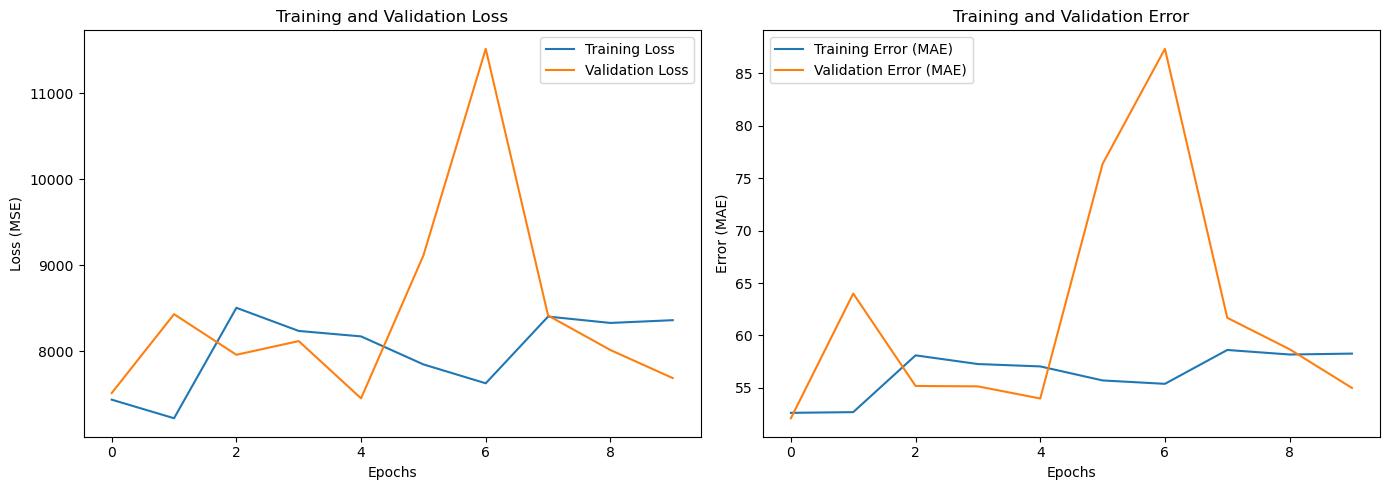

In [47]:
# Extract loss and error (e.g., MAE) values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_error = history.history['mae']  # Replace 'mae' with the error metric you're using
val_error = history.history['val_mae']  # Replace 'val_mae' with the error metric you're using

# Plot Loss
plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()

# Error Plot
plt.subplot(1, 2, 2)
plt.plot(train_error, label='Training Error (MAE)')
plt.plot(val_error, label='Validation Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('Error (MAE)')
plt.title('Training and Validation Error')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")



1574/1574 [==============================] - 8s 5ms/step - loss: 7651.5020 - mae: 54.6636
Test Loss: 7651.5020, Test MAE: 54.6636


In [51]:
len(y_pred),len(y_test),len(y_pred[1]),len(y_test[1])

(50368, 50368, 25, 25)

In [52]:
print(y_pred)

[[176.96735  177.31474  176.31984  ... 177.12225  177.73357  177.34616 ]
 [102.83946  102.66733  102.83809  ... 102.955605 102.97775  103.0136  ]
 [ 55.419178  55.357998  55.371414 ...  55.36868   55.523193  55.453625]
 ...
 [102.83946  102.66733  102.83809  ... 102.955605 102.97775  103.0136  ]
 [102.83946  102.66733  102.83809  ... 102.955605 102.97775  103.0136  ]
 [ 10.709717  10.894217  10.703311 ...  10.692553  10.886373  10.728571]]


In [53]:
print(y_test)

[[234.76950073 233.8918457  232.73049927 ... 249.46807861 259.03369141
  256.44503784]
 [ 72.90000153  73.23000336  72.69000244 ...  73.62000275  74.41000366
   74.08999634]
 [ 40.08000183  39.72333145  39.8433342  ...  39.91333389  39.86000061
   39.78333282]
 ...
 [ 76.46946716  76.76526642  77.69084167 ...  77.38549805  78.60687256
   80.17175293]
 [ 36.49000168  36.70999908  36.22999954 ...  35.77999878  35.50999832
   35.56999969]
 [ 12.68999958  12.30000019  12.67000008 ...  12.93000031  12.89999962
   12.82999992]]


In [54]:
# Save the trained model
model.save('lstm_model_general_500.h5')

/opt/progs/miniconda3/envs/ams_project/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Inferencing

In [ ]:
# Load the trained model
model = load_model('lstm_model_general.h5')

In [59]:
def prepare_inference_data(company_df, sequence_length=60):
    """
    Prepare input data for inference for a single company.
    Args:
        company_df (DataFrame): The DataFrame for a specific company.
        sequence_length (int): The number of past days to consider as input.

    Returns:
        numpy array: The input data ready for prediction.
    """
    # Ensure data is sorted by date
    company_df = company_df.sort_index()

    # Select relevant input features (exclude targets)
    input_features = company_df.filter(regex="^(?!.*target).*").values

    # Take the last `sequence_length` days as input for prediction
    if len(input_features) >= sequence_length:
        input_sequence = input_features[-sequence_length:]
        return np.expand_dims(input_sequence, axis=0)  # Add batch dimension
    else:
        raise ValueError("Insufficient data for inference (less than sequence length).")


In [62]:
company_df_input = {}
def get_predictions_for_all_companies(all_dfs, model, sequence_length=1):
    """
    Get predictions for all companies using the trained model.
    Args:
        all_dfs (dict): Dictionary of company DataFrames.
        model: Trained LSTM model.
        sequence_length (int): Number of past days to consider as input.

    Returns:
        dict: Predictions for each company.
    """
    predictions = {}
    
    for company, df in all_dfs.items():
        try:
            # Prepare data for inference
            input_data = prepare_inference_data(df, sequence_length=sequence_length)
            company_df_input[company] = input_data
            
            # Make predictions
            pred = model.predict(input_data)
            
            # Store predictions
            predictions[company] = pred.flatten()  # Flatten the array for readability
            print(f"Predictions for {company}: {pred.flatten()}")
        
        except ValueError as e:
            print(f"Skipping {company}: {e}")

    return predictions

# Get predictions for all companies
predictions = get_predictions_for_all_companies(all_dfs, model, sequence_length=60)


1/1 [==============================] - 0s 22ms/step
Predictions for df_AAPL: [56.801254 56.732742 56.705776 56.67417  56.811554 56.710457 56.703117
 56.638515 56.915035 56.75484  56.550545 56.290154 56.596928 56.83077
 56.909447 56.971436 56.834164 56.673832 57.11828  56.7683   56.512383
 56.873047 56.874454 56.97342  56.850136]
1/1 [==============================] - 0s 51ms/step
Predictions for df_NVDA: [56.82429  56.755913 56.72904  56.697258 56.83479  56.733597 56.72629
 56.661663 56.93805  56.777992 56.573822 56.313263 56.620213 56.853992
 56.932724 56.994583 56.8574   56.697044 57.141537 56.791424 56.535522
 56.896324 56.897636 56.99685  56.873375]
1/1 [==============================] - 0s 54ms/step
Predictions for df_MSFT: [56.801254 56.732742 56.705776 56.67417  56.811554 56.710457 56.703117
 56.638515 56.915035 56.75484  56.550545 56.290154 56.596928 56.83077
 56.909447 56.971436 56.834164 56.673832 57.11828  56.7683   56.512383
 56.873047 56.874454 56.97342  56.850136]
1/1 [==

In [61]:
import pickle

with open('new_predicitons.pkl', 'wb') as file:
    pickle.dump(predictions, file)

In [ ]:
all_dfs

In [63]:
import pickle

with open('updated_all_dfs.pkl', 'wb') as file:
    pickle.dump(all_dfs, file)